# A comparison of statistical and deep learning methods for survival analysis in credit risk

The following code is supplementary to a bachelor's thesis submitted at the Chair of Information Systems at Humboldt-Universität zu Berlin.

The packages (with version numbers) used in this thesis are given as follows:

Note: the package pysurvival only works under the operating system linux. For this thesis, the environment was created with WSL with Ubuntu 20.04 (https://docs.microsoft.com/en-us/windows/wsl/install-win10). Furthermore, it was found that some models are susceptible to different hardware environments (see https://machinelearningmastery.com/different-results-each-time-in-machine-learning/). The notebook's author based his findings on the results as presented in this notebook.

For reproducability, random seeds were set for all models with the exception of Random Survival Forest (not implementable).

## Data Processing + Explorative Analaysis

The data used is provided by International Financial Research Ltd. (http://www.internationalfinancialresearch.org/data.html). The data can be acessed through the site http://www.deepcreditrisk.com/data--code.html.

(Roesch, D., & Scheule, H. (2020). Deep Credit Risk: Machine Learning with Python, Amazon) <br> (Baesens, Bart, Daniel Roesch, and Harald Scheule. Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS. John Wiley & Sons, 2016.)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%pylab inline

data_raw = pd.read_csv("mortgage.csv")
print("The raw mortgage dataset has the following shape: {}.".format(data_raw.shape))

# Turn panel data into cross sectional data
data = data_raw.copy()
data = data.groupby('id').last() # this can be done, because defaulted borrowers only default on the last observation

print("The unmodified cross sectional mortgage dataset has the following shape: {}.".format(data.shape))

Populating the interactive namespace from numpy and matplotlib
The raw mortgage dataset has the following shape: (622489, 23).
The unmodified cross sectional mortgage dataset has the following shape: (50000, 22).


In [2]:
# Add 'duration' column as time event
data['duration'] = data['time'] - data['orig_time']

# Delete other time variables which are not of interest
data = data.drop(['time', 'orig_time', 'first_time', 'mat_time'], axis = 1)

# Delete other event variables which are not of interest and will correlate with the event of interest
data = data.drop(['status_time', 'payoff_time'], axis = 1) # Event of interest is the default, not payoff or other

# Creating the time and event columns
time_column = 'duration'
event_column = 'default_time'

# Creating a features vector to refer to the explanatory variables easier
features = np.setdiff1d(data.columns, [time_column, event_column]).tolist()

# Checking for null values and removing them
N_null = sum(data[features].isnull().sum())
data = data.dropna()
print("The raw_dataset contains {} null values".format(N_null))

The raw_dataset contains 18 null values


### Correlation Matrix of Features

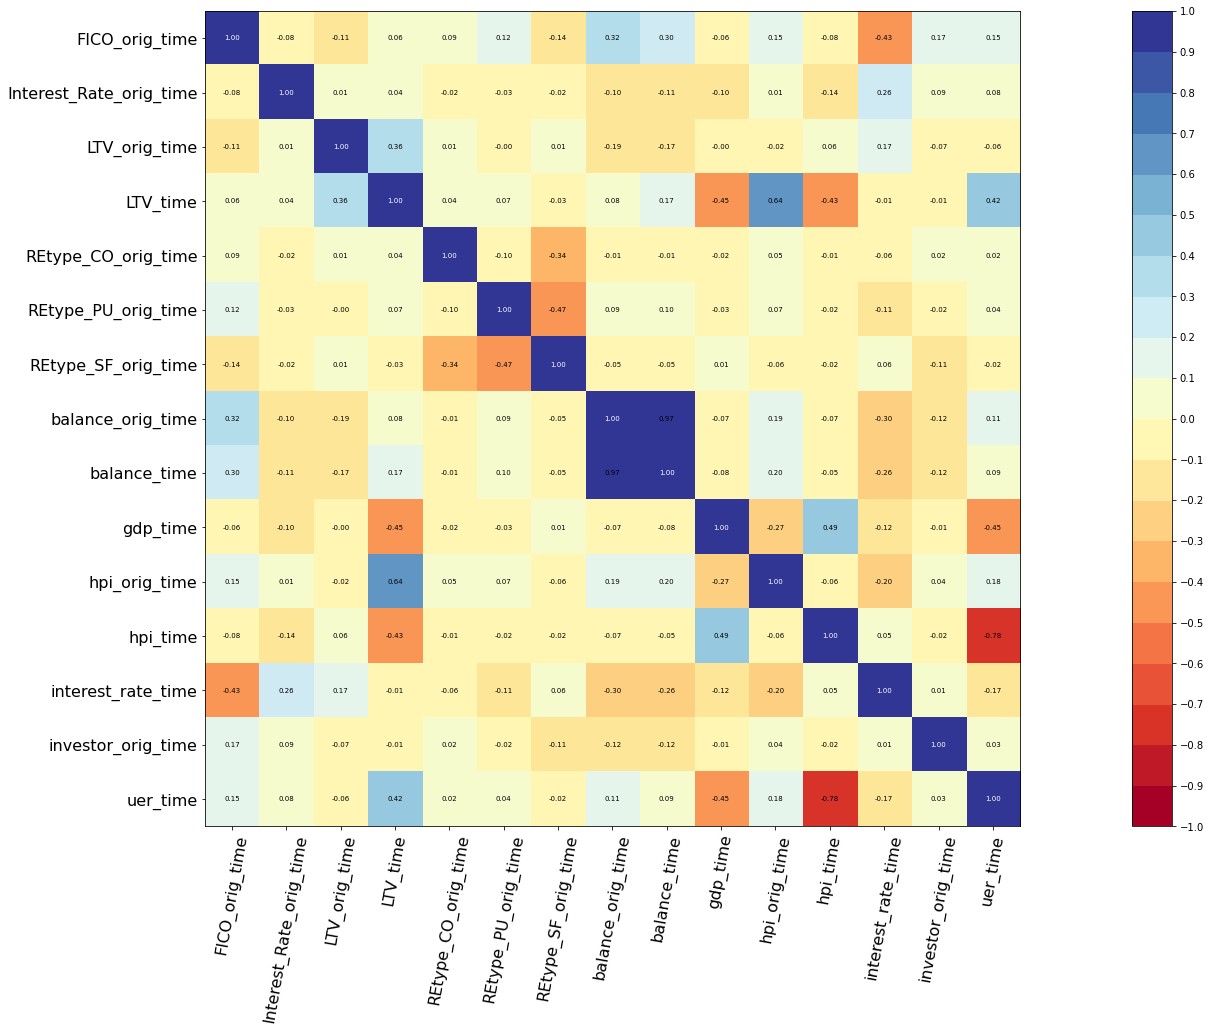

In [3]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(data[features], figure_size=(40,15), text_fontsize=7)

In [4]:
# Remove strongly correlated features
to_remove = ['hpi_time', 'hpi_orig_time', 'balance_time']
data = data.drop(to_remove, axis = 1)
features = np.setdiff1d(features, to_remove).tolist()

# Number of samples in the final modified dataset
N = data.shape[0]

print("The final modified dataset has the following shape: {}.".format(data.shape))

The final modified dataset has the following shape: (49982, 14).


### Event Distribution

In [5]:
freq = pd.crosstab(index=data['default_time'], columns='count')
print(freq)

col_0         count
default_time       
0             34833
1             15149


<BarContainer object of 2 artists>

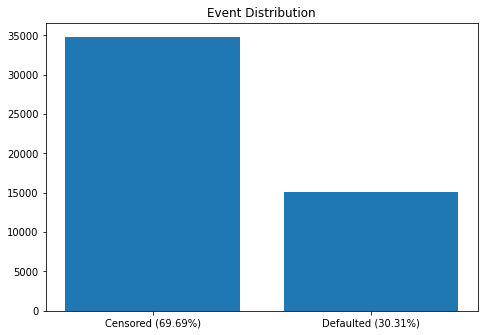

In [6]:
# Create Bar Chart for Event Distribution, not used in thesis
share_cen = (freq['count'][0]/N) * 100
share_def = (freq['count'][1]/N) * 100

x = ['Censored ({:.2f}%)'.format(share_cen), 'Defaulted ({:.2f}%)'.format(share_def)]
y = freq['count']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title('Event Distribution')
ax.bar(x,y)

## Creating and Training Models

### Statistical Models with PySurvival

In [7]:
# Split Data for statistical Models
from sklearn.model_selection import train_test_split
X_train, X_test, E_train, E_test, T_train, T_test = train_test_split(data[features], data[event_column], data[time_column], test_size = 0.4, random_state = 42)

#### CoxPH

In [8]:
from pysurvival.models.semi_parametric import CoxPHModel

coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr = 1e-2, l2_reg = 1e-2, init_method='zeros')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 86736.936 - ||grad||^2 = 11166.40060
 * Iteration #2 - Loss = 86631.723 - ||grad||^2 = 11054.48947
 * Iteration #3 - Loss = 86528.939 - ||grad||^2 = 10943.71010
 * Iteration #4 - Loss = 86428.505 - ||grad||^2 = 10834.05052
 * Iteration #5 - Loss = 86330.346 - ||grad||^2 = 10725.49895
 * Iteration #6 - Loss = 86234.390 - ||grad||^2 = 10618.04374
 * Iteration #7 - Loss = 86140.570 - ||grad||^2 = 10511.67339
 * Iteration #8 - Loss = 86048.819 - ||grad||^2 = 10406.37654
 * Iteration #9 - Loss = 85959.077 - ||grad||^2 = 10302.14199
 * Iteration #10 - Loss = 85871.285 - ||grad||^2 = 10198.95866
 * Iteration #11 - Loss = 85785.385 - ||grad||^2 = 10096.81560
 * Iteration #12 - Loss = 85701.325 - ||grad||^2 = 9995.70203
 * Iteration #13 - Loss = 85619.052 - ||grad||^2 = 9895.60725
 * Iteration #14 - Loss = 85538.517 - ||grad||^2 = 9796.52072
 * Iteration #15 - Loss = 85459.673 - ||grad||^2 = 9698.43200
 * Iteration #16 - Loss = 853

CoxPHModel

#### Parametric Models

In [9]:
from pysurvival.models.parametric import ExponentialModel
from pysurvival.models.parametric import WeibullModel
from pysurvival.models.parametric import LogLogisticModel

In [10]:
weib = WeibullModel()
weib.fit(X_train, T_train, E_train, lr=1e-2, init_method='zeros',
    optimizer ='adam', l2_reg = 1e-3, num_epochs=2000)

% Completion: 100%|*********************************************|Loss: 39128.83


WeibullModel

In [11]:
exp = ExponentialModel()
exp.fit(X_train, T_train, E_train, lr=1e-3, init_method='zeros',
    optimizer ='adam', l2_reg = 1e-4, num_epochs=2000)

% Completion: 100%|*********************************************|Loss: 41432.16


ExponentialModel

In [12]:
llm = LogLogisticModel()
llm.fit(X_train, T_train, E_train, lr=1e-3, init_method='zeros',
    optimizer ='adam', l2_reg = 1e-4, num_epochs=2000)

% Completion: 100%|*********************************************|Loss: 29282.46


LogLogisticModel

### Machine Learning

#### Random Survival Forests with PySurvival

In [13]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import torch

rsf = RandomSurvivalForestModel(num_trees = 200)

rsf.fit(X_train, T_train, E_train, max_features = "sqrt", max_depth = 5, min_node_size = 20)

RandomSurvivalForestModel

### Deep Learning Models with PyCox

In [14]:
from sklearn_pandas import DataFrameMapper

# Building training, testing and validation sets
df_train = data.copy()
df_test = df_train.sample(frac=0.4, random_state = 42)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2, random_state = 42)
df_train = df_train.drop(df_val.index)

# Standardize continuous variables to improve model performance
cols_stand = ['LTV_time', 'interest_rate_time', 'gdp_time', 'uer_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time']
cols_leave = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'default_time', 'duration']

standardize = [([col], None) for col in cols_stand]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# Create function to get target values T and E
get_target = lambda df: (df['duration'].values, df['default_time'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

#### Deepsurv

In [15]:
from pycox.models import CoxPH # DeepSurv is referred to as CoxPH in PyCox
import torchtuples as tt

In [16]:
#Set seed for reproducibility
np.random.seed(321)
_ = torch.manual_seed(321)

In [17]:
n_nodes = 256
in_features = x_train.shape[1]
num_nodes = [n_nodes, n_nodes, n_nodes, n_nodes]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False

net_ds = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)
DSm = CoxPH(net_ds, tt.optim.Adam)

In [18]:
DSm = CoxPH(net_ds, tt.optim.Adam)
batch_size = 128

# Finding the best learning rate from this model
lrfinder = DSm.lr_finder(x_train, y_train, batch_size, tolerance=10)
#_ = lrfinder.plot()
DS_lr = lrfinder.get_best_lr()
DSm.optimizer.set_lr(DS_lr)
print(DS_lr)

0.0001


In [19]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
DS = DSm.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[5s / 5s],		train_loss: 4.2552,	val_loss: 4.0819
1:	[5s / 11s],		train_loss: 4.1809,	val_loss: 4.0693
2:	[6s / 18s],		train_loss: 4.1516,	val_loss: 4.0726
3:	[6s / 24s],		train_loss: 4.1369,	val_loss: 4.0655
4:	[6s / 31s],		train_loss: 4.1263,	val_loss: 4.0461
5:	[6s / 37s],		train_loss: 4.0542,	val_loss: 3.9316
6:	[6s / 43s],		train_loss: 3.9588,	val_loss: 3.6806
7:	[6s / 49s],		train_loss: 3.8386,	val_loss: 3.6515
8:	[6s / 56s],		train_loss: 3.7565,	val_loss: 3.5341
9:	[6s / 1m:3s],		train_loss: 3.7700,	val_loss: 3.5081
10:	[6s / 1m:10s],		train_loss: 3.6646,	val_loss: 3.3733
11:	[6s / 1m:16s],		train_loss: 3.6438,	val_loss: 3.4607
12:	[5s / 1m:22s],		train_loss: 3.5953,	val_loss: 3.4178
13:	[6s / 1m:28s],		train_loss: 3.5550,	val_loss: 3.2275
14:	[6s / 1m:35s],		train_loss: 3.5062,	val_loss: 3.2150
15:	[6s / 1m:41s],		train_loss: 3.4773,	val_loss: 3.2032
16:	[6s / 1m:48s],		train_loss: 3.4162,	val_loss: 3.1392
17:	[6s / 1m:54s],		train_loss: 3.4340,	val_loss: 3.1849
18:	[6s / 2m:

## Deephit

In [20]:
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
# For Network Building
import torch
from pycox.models import DeepHitSingle

In [21]:
#Set seed for reproducibility
np.random.seed(123)
_ = torch.manual_seed(123)

In [22]:
num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['default_time'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

durations_test, events_test = get_target(df_test)

In [23]:
in_features = x_train.shape[1]
num_nodes = [n_nodes, n_nodes, n_nodes, n_nodes, n_nodes, n_nodes]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [24]:
DHm = DeepHitSingle(net, tt.optim.Adam, alpha = 0.2, sigma = 0.1, duration_index=labtrans.cuts)

batch_size = 256
lr_finder = DHm.lr_finder(x_train, y_train, batch_size, tolerance = 3)
DHm_lr = lr_finder.get_best_lr()
DHm.optimizer.set_lr(DHm_lr)
print(DHm_lr)

0.0001


In [25]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
DH = DHm.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[5s / 5s],		train_loss: 0.2985,	val_loss: 0.2643
1:	[5s / 10s],		train_loss: 0.2816,	val_loss: 0.2603
2:	[5s / 15s],		train_loss: 0.2728,	val_loss: 0.2562
3:	[5s / 20s],		train_loss: 0.2677,	val_loss: 0.2537
4:	[4s / 25s],		train_loss: 0.2628,	val_loss: 0.2522
5:	[5s / 30s],		train_loss: 0.2611,	val_loss: 0.2522
6:	[5s / 35s],		train_loss: 0.2561,	val_loss: 0.2483
7:	[4s / 40s],		train_loss: 0.2534,	val_loss: 0.2445
8:	[4s / 45s],		train_loss: 0.2494,	val_loss: 0.2383
9:	[4s / 50s],		train_loss: 0.2448,	val_loss: 0.2422
10:	[4s / 55s],		train_loss: 0.2449,	val_loss: 0.2344
11:	[4s / 1m:0s],		train_loss: 0.2406,	val_loss: 0.2309
12:	[4s / 1m:4s],		train_loss: 0.2375,	val_loss: 0.2416
13:	[4s / 1m:9s],		train_loss: 0.2332,	val_loss: 0.2160
14:	[4s / 1m:13s],		train_loss: 0.2263,	val_loss: 0.2184
15:	[4s / 1m:17s],		train_loss: 0.2178,	val_loss: 0.2000
16:	[4s / 1m:21s],		train_loss: 0.2151,	val_loss: 0.2060
17:	[4s / 1m:26s],		train_loss: 0.2047,	val_loss: 0.1941
18:	[4s / 1m:30s],		t

## N-MTLR

In [26]:
from pycox.models import MTLR #N-MTLR is called MTLR in PyCox

In [27]:
#Set seed for reproducibility
np.random.seed(777)
_ = torch.manual_seed(777)

In [28]:
num_durations = 10
labtrans = MTLR.label_transform(num_durations)
get_target = lambda df: (df['duration'].values, df['default_time'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [29]:
in_features = x_train.shape[1]
num_nodes = [256, 256]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [30]:
NMTLRm = MTLR(net, tt.optim.Adam, duration_index = labtrans.cuts)

In [31]:
batch_size = 256
lr_finder = NMTLRm.lr_finder(x_train, y_train, batch_size, tolerance=6)
NMTLR_lr = lr_finder.get_best_lr()
NMTLRm.optimizer.set_lr(NMTLR_lr)
print(NMTLR_lr)

0.0007054802310718675


In [32]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
NMTLR = NMTLRm.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[2s / 2s],		train_loss: 0.7918,	val_loss: 0.7703
1:	[2s / 5s],		train_loss: 0.6477,	val_loss: 0.6311
2:	[2s / 7s],		train_loss: 0.5453,	val_loss: 0.6745
3:	[2s / 9s],		train_loss: 0.4994,	val_loss: 0.8249
4:	[2s / 12s],		train_loss: 0.4541,	val_loss: 0.4570
5:	[2s / 14s],		train_loss: 0.4541,	val_loss: 0.4254
6:	[2s / 17s],		train_loss: 0.4391,	val_loss: 1.3772
7:	[2s / 19s],		train_loss: 0.4535,	val_loss: 1.6161
8:	[2s / 21s],		train_loss: 0.4495,	val_loss: 0.3902
9:	[2s / 24s],		train_loss: 0.3971,	val_loss: 0.9556
10:	[2s / 26s],		train_loss: 0.3695,	val_loss: 2.1433
11:	[2s / 29s],		train_loss: 0.3879,	val_loss: 0.4497
12:	[2s / 32s],		train_loss: 0.3449,	val_loss: 0.3576
13:	[2s / 34s],		train_loss: 0.3439,	val_loss: 0.2937
14:	[2s / 36s],		train_loss: 0.3713,	val_loss: 1.1245
15:	[2s / 39s],		train_loss: 0.3404,	val_loss: 0.3366
16:	[2s / 41s],		train_loss: 0.3253,	val_loss: 0.3601
17:	[2s / 44s],		train_loss: 0.3142,	val_loss: 0.9028
18:	[2s / 47s],		train_loss: 0.3453,	val_l

# Evaluation

## Scores

### Evaluation of Statistical Models and RSF with PySurvival

In [33]:
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score

In [34]:
# Calculate C-index
coxph_cind = concordance_index(coxph, X_test, T_test, E_test)
weib_cind = concordance_index(weib, X_test, T_test, E_test)
exp_cind = concordance_index(exp, X_test, T_test, E_test)
llm_cind = concordance_index(llm, X_test, T_test, E_test)
rsf_cind = concordance_index(rsf, X_test, T_test, E_test)

/usr/local/lib/python3.8/dist-packages/pysurvival/models/semi_parametric.py:310: RuntimeWarning: overflow encountered in exp
  risk_score = np.exp(risk_score)


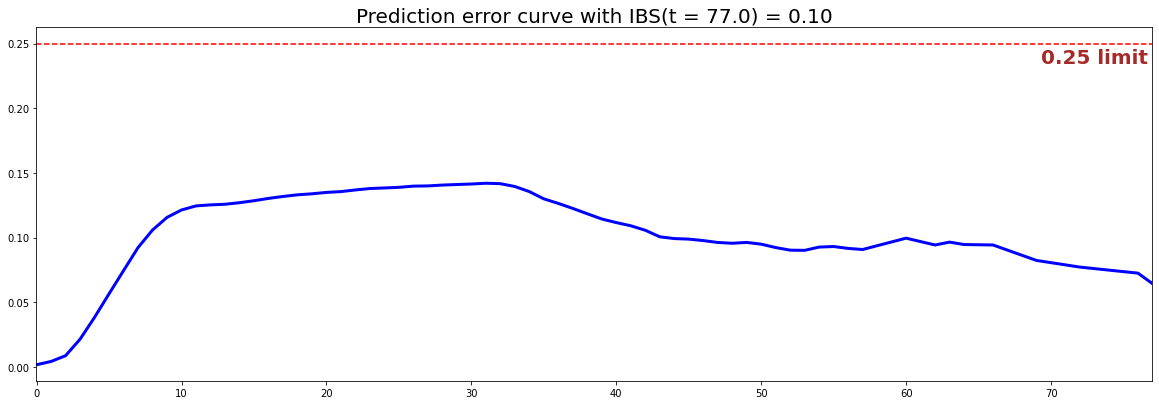

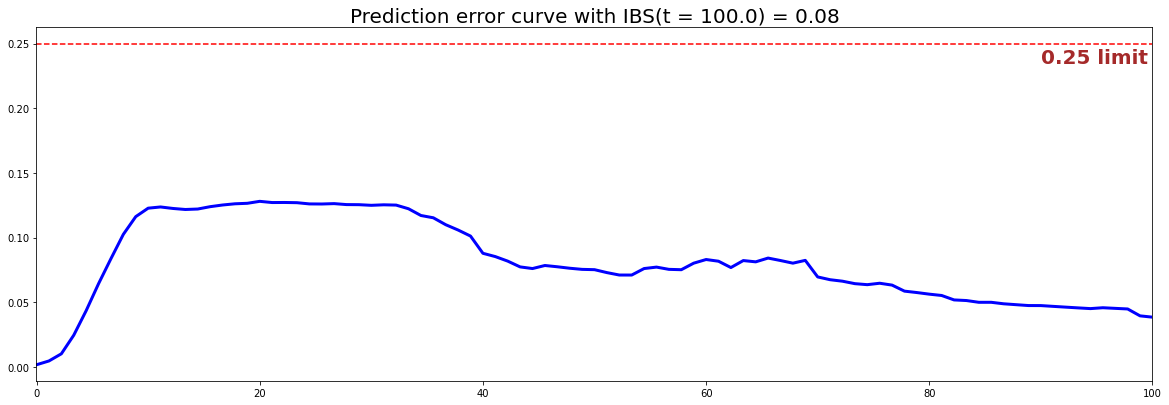

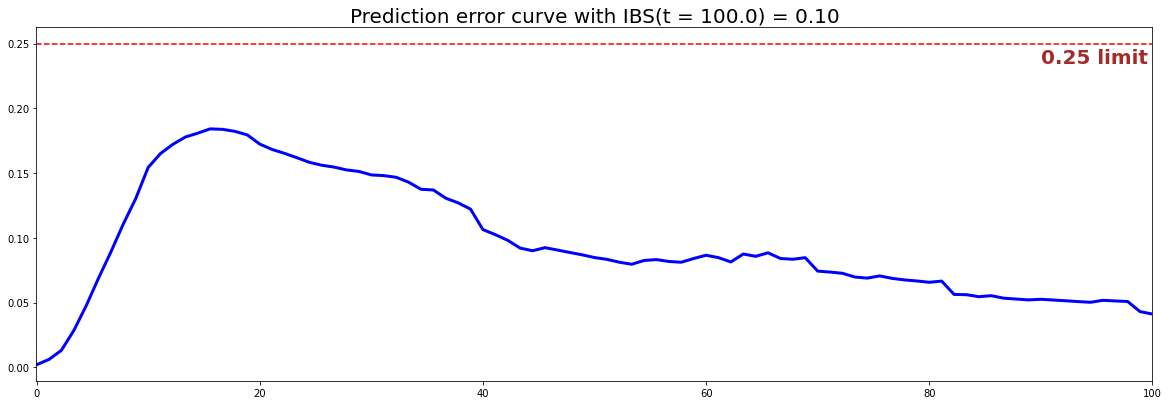

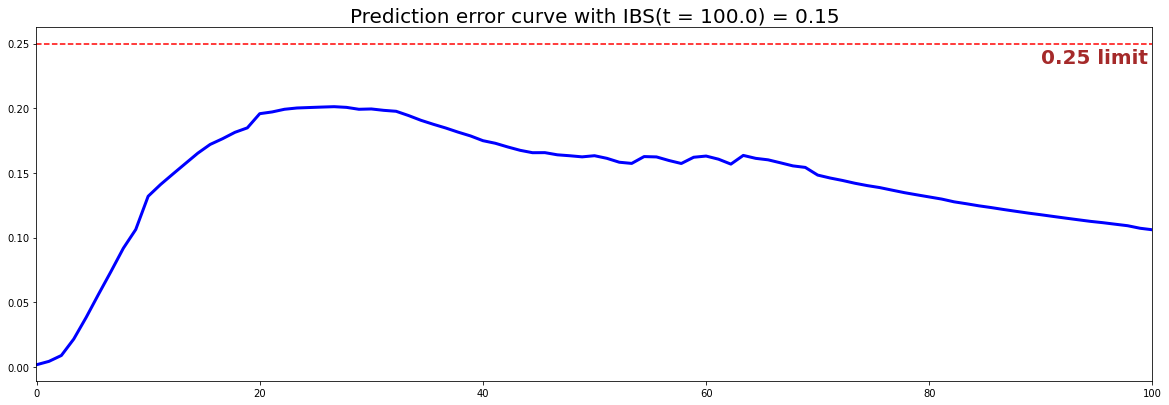

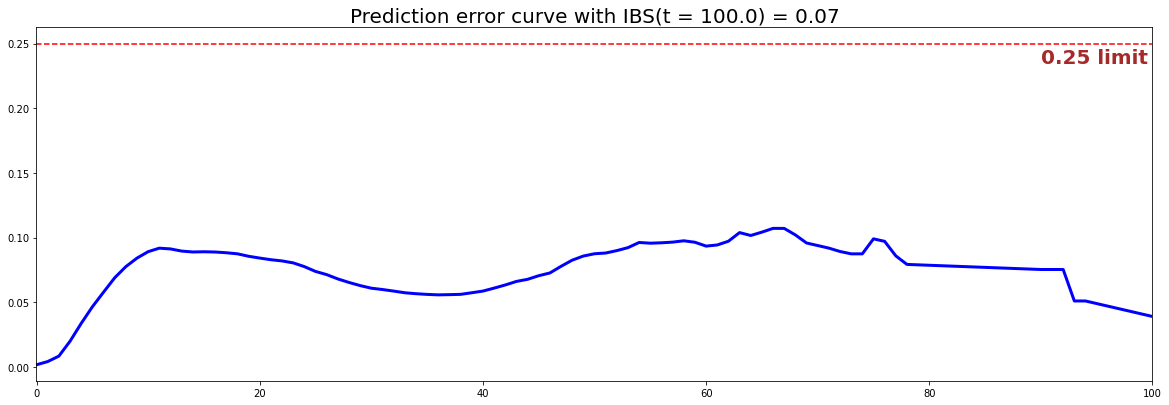

In [35]:
# Calculate IBS | graphs are generated automatically and cannot be disabled
coxph_ibs = integrated_brier_score(coxph, X_test, T_test, E_test, t_max = max(data.duration))
weib_ibs = integrated_brier_score(weib, X_test, T_test, E_test, t_max = max(data.duration))
exp_ibs = integrated_brier_score(exp, X_test, T_test, E_test, t_max = max(data.duration))
llm_ibs = integrated_brier_score(llm, X_test, T_test, E_test, t_max = max(data.duration))
rsf_ibs = integrated_brier_score(rsf, X_test, T_test, E_test, t_max = max(data.duration))

### Evaluation of Deep Learning Models with PyCox

In [36]:
from pycox.evaluation import EvalSurv
from sksurv.metrics import concordance_index_censored # used because pycox only offers C-index from Antolini (2015) (time dependent c-index) and for comparability, Harrell's C-index will be used which is available in scikit-survival

In [37]:
# Calculate C-index
DSm.compute_baseline_hazards() # Required for DeepSurv

DSsurv = DSm.predict_surv_df(x_test)
DHsurv = DHm.predict_surv_df(x_test)
NMTLRsurv = NMTLRm.predict_surv_df(x_test)

DS_ev = EvalSurv(DSsurv, durations_test, events_test, censor_surv = 'km')
DH_ev = EvalSurv(DHsurv, durations_test, events_test, censor_surv = 'km')
NMTLR_ev = EvalSurv(NMTLRsurv, durations_test, events_test, censor_surv = 'km')

DS_cind = concordance_index_censored(events_test.astype('bool'), durations_test, DSm.predict(x_test).flatten())[0]
DH_cind = concordance_index_censored(events_test.astype('bool'), durations_test, DHm.predict(x_test)[:,1])[0]
NMTLR_cind = concordance_index_censored(events_test.astype('bool'), durations_test, NMTLRm.predict(x_test)[:,1])[0]

In [38]:
# Calculate IBS
time_grid = np.linspace(0, durations_test.max(), 100)

DS_ibs = DS_ev.integrated_brier_score(time_grid) 
DH_ibs = DH_ev.integrated_brier_score(time_grid)
NMTLR_ibs = NMTLR_ev.integrated_brier_score(time_grid)

In [39]:
#Create Table with Performances
modelperformances = {'Model Name': ['CoxPH', 'Weibull', 'Exponential', 'Log-Logistic', 'Random Survival Forest', 'DeepSurv', 'DeepHit', 'N-MTLR'], 
                     'C-index': [coxph_cind, weib_cind, exp_cind, llm_cind, rsf_cind, DS_cind, DH_cind, NMTLR_cind], 
                     'Integrated Brier Score': [coxph_ibs, weib_ibs, exp_ibs, llm_ibs, rsf_ibs, DS_ibs, DH_ibs, NMTLR_ibs]}
modelperformances = pd.DataFrame(modelperformances).set_index('Model Name')
modelperformances.round(4)

,C-index,Integrated Brier Score
Model Name,,
CoxPH,0.7818,0.1030
Weibull,0.7843,0.0816
Exponential,0.7464,0.0970
Log-Logistic,0.7758,0.1468
Random Survival Forest,0.8544,0.0750
DeepSurv,0.9529,0.0331
DeepHit,0.9379,0.0736
N-MTLR,0.9623,0.0340


In [40]:
# Ranking of Model Performances by Harrell's C-index
modelperformances.round(4).sort_values(by=['C-index'], ascending = False)['C-index']

Model Name
N-MTLR                    0.9623
DeepSurv                  0.9529
DeepHit                   0.9379
Random Survival Forest    0.8544
Weibull                   0.7843
CoxPH                     0.7818
Log-Logistic              0.7758
Exponential               0.7464
Name: C-index, dtype: float64

In [41]:
# Ranking of Model Performances by IBS
modelperformances.round(4).sort_values(by=['Integrated Brier Score'])['Integrated Brier Score']

Model Name
DeepSurv                  0.0331
N-MTLR                    0.0340
DeepHit                   0.0736
Random Survival Forest    0.0750
Weibull                   0.0816
Exponential               0.0970
CoxPH                     0.1030
Log-Logistic              0.1468
Name: Integrated Brier Score, dtype: float64